In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

sns.set_style("whitegrid")

In [25]:
data= pd.read_csv("time_xios2_xios3.txt",sep=r"\s+")
data

,Time send/recv,Initialise,Finalise,nfields,operation,io_nodes,servers_per_node,client_nodes,xios_version
0,0.006640,0.942362,14.670459,8,write,1,12,8,xios-2
1,0.000639,1.222956,1.284618,1,write,8,8,16,xios-2
2,0.016664,1.059895,2.046742,8,write,8,12,8,xios-3
3,0.026811,0.915955,19.863398,16,write,4,1,8,xios-3
4,0.291915,0.978469,3.484231,16,write,8,12,1,xios-3
...,...,...,...,...,...,...,...,...,...
259,0.011692,0.965749,2.067910,4,write,4,8,8,xios-3
260,0.016043,1.073683,9.050921,8,write,1,12,8,xios-3
261,0.003607,0.902500,1.399635,4,write,8,12,8,xios-2
262,0.440281,0.853162,12.482166,16,write,8,1,1,xios-2


In [1]:
sns.scatterplot(data=data.query("client_nodes==16 & servers_per_node==12 & nfields==32"), y="Initialise", x="io_nodes", hue="xios_version", s=30)

NameError: name 'sns' is not defined

In [70]:
## Scatterplot
scatter_data = data.pivot(columns="xios_version",index=["nfields","io_nodes","client_nodes","servers_per_node"],values=["Time send/recv","Initialise","Finalise"])\
                .reset_index().dropna()
scatter_data


nfields io_nodes client_nodes servers_per_node Time send/recv  \
xios_version                                                        xios-2   
0                  1        1            1                1       0.008130   
1                  1        1            1                8       0.020411   
2                  1        1            1               12       0.010993   
3                  1        1            8                1       0.096652   
4                  1        1            8                8       0.001180   
..               ...      ...          ...              ...            ...   
128               32        8            1               12       0.968012   
129               32        8            8                1       0.573696   
130               32        8            8                8       0.096548   
132               32        8           16                1       0.843733   
133               32        8           16                8       0.135625   

                       Initialise             Finalise            
xios_version    xios-3     xios-2    xios-3     xios-2    xios-3  
0             0.014640   0.992682  0.861981  34.119719  3.052116  
1             0.011147   0.847147  0.915443   6.893430  2.815978  
2             0.021430   0.767417  0.928233   4.922774  2.056794  
3             0.003282   1.490661  0.980374  40.563620  4.075388  
4             0.007502   0.992785  1.087014   8.124173  2.058085  
..                 ...        ...       ...        ...       ...  
128           0.561076   0.910031  0.988250   5.487325  5.190052  
129           0.047215   0.993425  0.924486  22.097449  9.082379  
130           0.048109   0.916097  1.049384   6.726881  5.795682  
132           0.025044   1.038325  1.298131  21.870126  9.148219  
133           0.030309   1.396318  1.118149   6.375516  6.058605  

[129 rows x 10 columns]

In [222]:
def scatter_plot(scatter_data, time_column,ax=None):
    data = pd.DataFrame({
        "xios-2": scatter_data[time_column]["xios-2"],
        "xios-3": scatter_data[time_column]["xios-3"],
        "relative_performance": (1./scatter_data[time_column]["xios-3"] - 1./scatter_data[time_column]["xios-2"])*scatter_data[time_column]["xios-2"]
    })

    data["cmap"] = data["relative_performance"].apply(lambda x: 1.0 if x > 0 else 0)   
    
    diag=np.linspace(data["xios-3"].min(), data["xios-3"].max())
    ax.plot(diag, diag, color="black", linestyle="--")
    cmap = sns.color_palette("RdYlGn",n_colors=2)
    sns.scatterplot(data=data,x="xios-2", y="xios-3",hue="cmap", s=100,legend=None,palette=cmap, ax=ax)
    ax.set_xlabel(f" {time_column} xios-2 (s)")
    ax.set_ylabel(f" {time_column} xios-3 (s)")


## Averall comparison between xios2 and xios3

Below we show an overview of the difference in performance between xios2 and xios3.
We plot the correlation between time spent in xios2 and xios3 , in each of the three main phases:
- `Initialisation`: Time spent in the context closure on the clients.
- `Send/Recv`: Time spent sending data to the servers. If there is no back-pressure from the servers, refusing payloads from running out of memory , this should be equal to the time spent in sending data to the servers plus any data processing being executed on the clients
- `Finalise`: Time spent in context finalisation. This is the call is dominated from servers being busy processing incoming data. Most of the time spent in I/O \
            to the disk on the servers is captured here.

Each field is distributed on an uniform grid of shape `[70,896,896,6]` . The process grid is chosen as `[1,X,Y,6]` where X and Y are chosen such as X*Y = total number of ranks. This mimics the data layout used on lfric, where 6 corresponds the 6 different panels and 70 is the number of layers of the operational configuration.

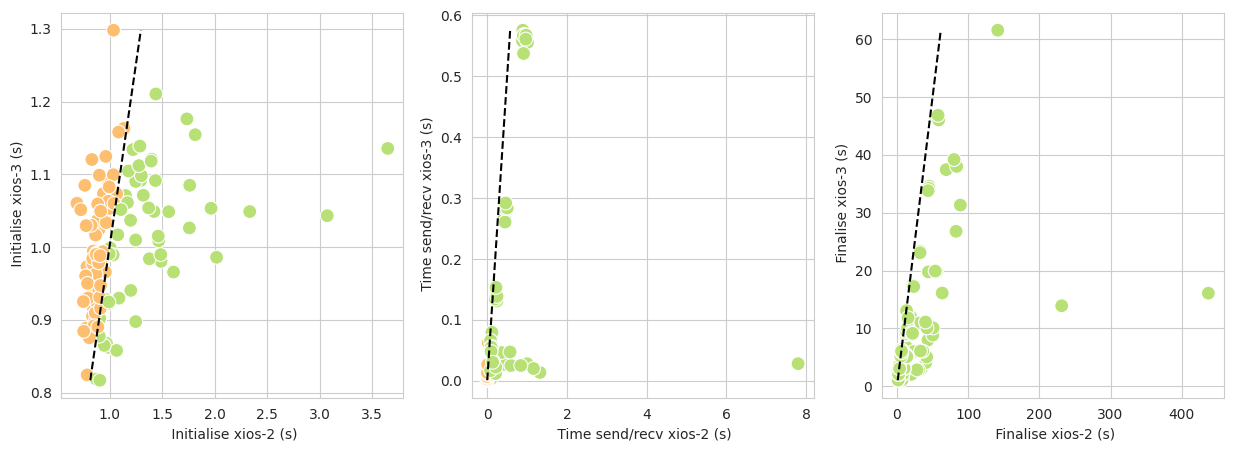

In [226]:
fig, axs = plt.subplots(1, 3 ,figsize=(15, 5))
scatter_plot(scatter_data, "Initialise",ax=axs[0])
scatter_plot(scatter_data, "Time send/recv",ax=axs[1])
scatter_plot(scatter_data, "Finalise",ax=axs[2])

Green points indicate that xios-3 is faster, while orange points indicate that xios-2 is faster. The dashed line indicates equal times in xios2 and xios3.
xios2 seems to have a bigger tail of runs which are slow to initialise. Jobs with a higher initialisation times seem faster in xios2. At smaller initialisation times, it seems xios2 has slightly smaller overheads. Latency of send/recv seems greatly reduced in xios3 compared to xios2. The time spent in finalisation dominates the run time.